In [9]:
import pandas as pd
import geopandas as gpd
from subprocess import call
from os.path import split, basename
from os import listdir
from tempfile import NamedTemporaryFile
import matplotlib.pyplot as plt
import geojson
%matplotlib inline
from matplotlib.colors import Normalize
import numpy as np
from shapely.geometry import Point, Polygon, mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from PIL import Image
plt.rcParams['figure.figsize'] = (10, 10)

# Process Datafile

In [2]:
DATAFILE = "../data/jan1981To.csv"
data = pd.read_csv(DATAFILE, parse_dates=['datetimef']).set_index('datetimef')

In [3]:
def pointsToGrid(data, x, y, z, outfile, xsize=100, ysize=100):
    _VRT = """
        <OGRVRTDataSource>
            <OGRVRTLayer name={name}>
                <SrcDataSource>{loc}</SrcDataSource>
                <GeometryType>wkbPoint</GeometryType>
                <GeometryField encoding="PointFromColumns" x={x} y={y} z={z}/>
            </OGRVRTLayer>
        </OGRVRTDataSource>
    """
    with NamedTemporaryFile('w', suffix = '.csv') as tmpf:
        # save csv
        tmpdir, tmpfname = split(tmpf.name)
        data[[x, y, z]].to_csv(tmpf)
        tmpf.flush()
        
        # create vrt
        vrtTmp = NamedTemporaryFile('w', dir=tmpdir, delete=False)
        vrt = _VRT.format(loc = tmpf.name,
                          name=tmpfname.split(".")[0], 
                          x = x, y = y, z = z)
        vrtTmp.write(vrt)
        vrtTmp.flush()
    
        # grid data
        call(["gdal_grid", vrtTmp.name, outfile, "-outsize", str(xsize), str(ysize), 
              "-a", "invdistnn:radius=30"])
        vrtTmp.close()
    







In [4]:
pointsToGrid(data.loc["1981-01-20 12:00"], 'lon', 'lat', 'To_Lizard', outfile='testout123.tif', xsize=500, ysize=500)

In [5]:
import rasterio
from rasterio.plot import show
from rasterio.features import shapes


| 0.01, 0.00,-109.07|
| 0.00, 0.01, 37.04|
| 0.00, 0.00, 1.00|
1.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0


/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


-10 0
[[ 0.56215382  0.56294517  0.56383544 ...  0.04516534  0.04344528
   0.04176669]
 [ 0.56077689  0.56156808  0.56246385 ...  0.04586625  0.044174
   0.04251912]
 [ 0.55935206  0.56014185  0.56104221 ...  0.04654781  0.0448867
   0.04325827]
 ...
 [ 0.69008443  0.692738    0.69548153 ... -0.16619656 -0.16251905
  -0.15931094]
 [ 0.69086951  0.69355044  0.69632279 ... -0.17197454 -0.16831321
  -0.16509562]
 [ 0.6916069   0.69431233  0.69711043 ... -0.17755301 -0.17391214
  -0.17069078]]


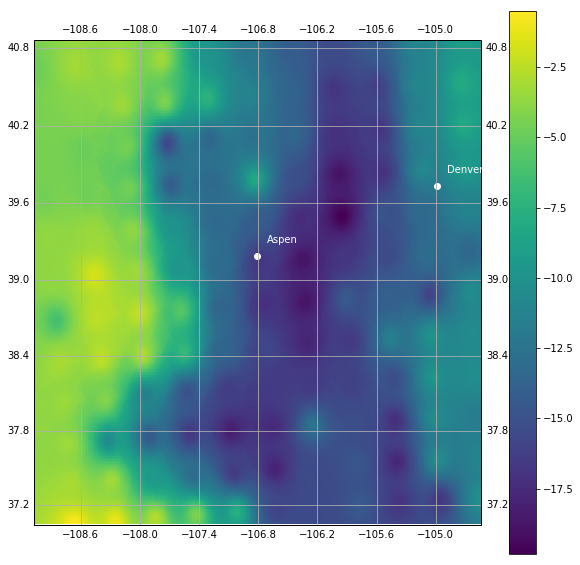

In [23]:
filename = 'testout123.tif'

threshold = -14
with rasterio.open(filename, 'r') as src:

        bounds = src.bounds
        # read image into ndarray
        im = src.read()

        print(src.affine)
        # transpose the array from (band, row, col) to (row, col, band)
        im = im.squeeze()
        # calculate extent of raster
        xmin = src.transform[0]
        xmax = src.transform[0] + src.transform[1]*src.width
        ymin = src.transform[3] + src.transform[5]*src.height
        ymax = src.transform[3]
        
        stress_thresh_shapes= list(shapes(np.uint8(im < threshold)))#, transform=src.transform))
        stress_thresh_polys = []
        for poly, value in stress_thresh_shapes:
            print(value)
            if(value == 1.0):
                poly['coordinates'] = [src.affine * xy for xy in poly['coordinates'][0]]
                stress_thresh_polys.append(Polygon(shell=poly['coordinates']))
            
        with open("piltest.gif.geojson", 'w') as gjf:
            geojson.dump(geojson.GeometryCollection(stress_thresh_polys), gjf)

        # define cartopy crs for the raster, based on rasterio metadata
        crs = ccrs.PlateCarree()

        # create figure
        ax = plt.axes(projection=ccrs.Mercator().GOOGLE)
        ax.set_extent([bounds.left, bounds.right, bounds.bottom, bounds.top])
        ax.set_xmargin(0.05)
        ax.set_ymargin(0.10)

        
        
        # plot raster
        plt.imshow(im, origin='upper', extent=[xmin, xmax, ymin, ymax], transform=crs)

    
        # plot coastlines
        ax.gridlines(draw_labels=True)
        plt.colorbar()

        
        reflat_a, reflon_a = 39.1911, -106.8175
        reflat_b, reflon_b = 39.7392, -104.9903
        ax.text(reflon_a+.1, reflat_a+.1, 'Aspen', transform=crs, color='white')
        ax.text(reflon_b+.1, reflat_b+.1, "Denver", transform=crs, color='white')
        ax.scatter(reflon_a, reflat_a, color='white', marker='o', transform=crs)
        ax.scatter(reflon_b, reflat_b, color='white', marker='o', transform=crs)
        plt.savefig('testfigure.png')
        #plt.show()
        
        
        ## another approach@
        ### normalize
        im = np.flip(im, 0)

    
        norm = Normalize(vmin=-10, vmax=0, clip=False)
        print(norm.vmin, norm.vmax)
        print(norm(im))
        im = Image.fromarray(np.uint8(plt.cm.viridis(norm(im)) * 255))
        im.show()
        
        im.save("piltest.gif")
        with open('piltest.ref', 'w') as f:
            f.write("{},{},{},{},{}".format('piltest.gif', bounds.left, bounds.right, bounds.bottom, bounds.top))
        
        
        

        

        


In [26]:
!more piltest.gif.geojson

{"geometries": [], "type": "GeometryCollection"}
>

---


In [78]:
hour = data.loc["1981-01-01 12:00"]
geom = [Point(d['lon'], d['lat']) for _, d in hour.iterrows()]
hour_geo = gpd.GeoDataFrame(data=hour['To_Lizard'], geometry=geom)
hour_geo.to_file('hour.geojson', driver="GeoJSON")


In [79]:
!head hour.geojson

{
"type": "FeatureCollection",
"features": [
{ "type": "Feature", "properties": { "To_Lizard": -2.7346669852442504 }, "geometry": { "type": "Point", "coordinates": [ -108.657, 37.0422 ] } },
{ "type": "Feature", "properties": { "To_Lizard": -2.6254874658077902 }, "geometry": { "type": "Point", "coordinates": [ -108.247, 37.0702 ] } },
{ "type": "Feature", "properties": { "To_Lizard": -2.6303045779390599 }, "geometry": { "type": "Point", "coordinates": [ -107.836, 37.0967 ] } },
{ "type": "Feature", "properties": { "To_Lizard": -2.0969706082837001 }, "geometry": { "type": "Point", "coordinates": [ -107.426, 37.1219 ] } },
{ "type": "Feature", "properties": { "To_Lizard": -2.0016052137414699 }, "geometry": { "type": "Point", "coordinates": [ -107.014, 37.1458 ] } },
{ "type": "Feature", "properties": { "To_Lizard": -4.515697483118231 }, "geometry": { "type": "Point", "coordinates": [ -106.603, 37.1683 ] } },
{ "type": "Feature", "properties": { "To_Lizard": -3.4023818115020399 }, "geomet

In [38]:
from affine import Affine

Init signature: Affine(*members)
Docstring:     
Two dimensional affine transform for 2D linear mapping.

Parallel lines are preserved by these transforms. Affine transforms
can perform any combination of translations, scales/flips, shears,
and rotations.  Class methods are provided to conveniently compose
transforms from these operations.

Internally the transform is stored as a 3x3 transformation matrix.
The transform may be constructed directly by specifying the first
two rows of matrix values as 6 floats. Since the matrix is an affine
transform, the last row is always ``(0, 0, 1)``.

N.B.: multiplication of a transform and an (x, y) vector *always*
returns the column vector that is the matrix multiplication product
of the transform and (x, y) as a column vector, no matter which is
on the left or right side. This is obviously not the case for
matrices and vectors in general, but provides a convenience for
users of this class.

:param members: 6 floats for the first two matrix rows.
